# Tests and implementation for the RFClassifier class.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from estimator import RFClassifier, classical_weights, V1_inspired_weights, haltere_inspired_weights

## Implementation for V1 weights

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data, labels = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
# select the linear classifier
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver='saga')

# non-linearity
relu = lambda x: np.maximum(0, x)

# classify using classical weights
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(width=40, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

# classify using V1 weights
kwargs = {'t': 5, 'l': 3}
params_neural = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity':relu, 'clf': logit}
clf = RFClassifier(width=40, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

## Implementation for haltere weights

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data, labels = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
# linear classifier
logit = LogisticRegression(solver='saga')

# non-linearity
cos = lambda x: np.cos(x)
relu = lambda x: np.maximum(x, 0)

# params
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_classical = clf.W_[0]

kwargs = {'lowcut': 4, 'highcut': 6}
params_neural = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_neural = clf.W_[0]

fig = plt.figure()
plt.plot(W_classical, c='k')
plt.plot(W_neural)

### Test the parallelized function for RFClassifer

In [ ]:
from estimator import RFClassifier, classical_weights, relu, haltere_inspired_weights, V1_inspired_weights, clf_wrapper
from data_fns import load_mnist
from sklearn.linear_model import SGDClassifier
import numpy as np
import numpy.linalg as la

In [ ]:
# use dask
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)

In [ ]:
X_train, y_train, X_test, y_test = load_mnist('data/mnist/')
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
%%time
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-4, n_iter_no_change=10, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
train_err, test_err, clf = clf_wrapper(RFClassifier, params, X_train, y_train, X_test, y_test, return_clf=True)
print(test_err)

In [ ]:
%%time
from estimator import parallelized_clf
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-5, n_iter_no_change=30, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
mean_train_err, std_train_err, mean_test_err, std_test_err = parallelized_clf(RFClassifier, params, X_train, y_train,
                                                                             X_test, y_test, n_iters=5, 
                                                                              return_clf=False)

### test of fashion-mnist real quick

In [ ]:
from data_fns import load_fashion_mnist
X_train, y_train, X_test, y_test = load_mnist('data/fashion_mnist/')
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
%%time
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-4, n_iter_no_change=10, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
train_err, test_err, clf = clf_wrapper(RFClassifier, params, X_train, y_train, X_test, y_test, return_clf=True)
print(test_err)

In [ ]:
%%time
from estimator import parallelized_clf
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-5, n_iter_no_change=30, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
mean_train_err, std_train_err, mean_test_err, std_test_err = parallelized_clf(RFClassifier, params, X_train, y_train,
                                                                             X_test, y_test, n_iters=5, 
                                                                              return_clf=False)

## Test the norm of classical weights vs bio-inspired weights

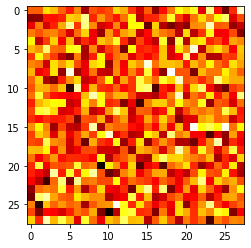

In [106]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from estimator import classical_weights, V1_inspired_kernel_matrix, V1_inspired_weights,  V1_inspired_weights_for_center

W = classical_weights(20, 784)
W /= la.norm(W, axis=0).reshape(1, -1)
K = np.dot(W.T, W)

fig = plt.figure()
plt.imshow(W[0].reshape(28, 28), cmap='hot')

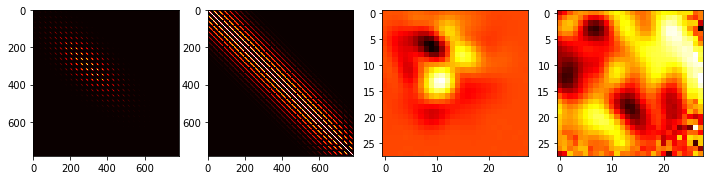

In [74]:
K = V1_inspired_kernel_matrix(784, 5, 3, [10, 10])
normalize = np.diag(np.diag(1 / np.sqrt(K)))
K_norm = normalize @ K @ normalize

L = la.cholesky(K)
W = np.dot(L, np.random.randn(784))

L = la.cholesky(K_norm)
W_norm =  np.dot(L, np.random.randn(784))


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(141)
plt.imshow(K, cmap='hot')

ax = fig.add_subplot(142)
plt.imshow(K_norm, cmap='hot')


ax = fig.add_subplot(143)
plt.imshow(W.reshape(28, 28), cmap='hot')

ax = fig.add_subplot(144)
plt.imshow(W_norm.reshape(28, 28), cmap='hot')

(64782.78014467197, 784.0)

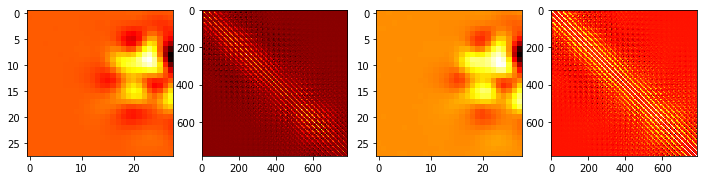

In [96]:
W = V1_inspired_weights(100, 784, 5, 3)
W_norm = W / la.norm(W, axis=0).reshape(1, -1)
K = np.dot(W.T, W)
K_norm = np.dot(W_norm.T, W_norm)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(141)
plt.imshow(W[2].reshape(28, 28), cmap='hot')

ax = fig.add_subplot(142)
plt.imshow(K, cmap='hot')


ax = fig.add_subplot(143)
plt.imshow(W_norm[2].reshape(28, 28), cmap='hot')

ax = fig.add_subplot(144)
plt.imshow(K_norm, cmap='hot')

np.trace(K), np.trace(K_norm)

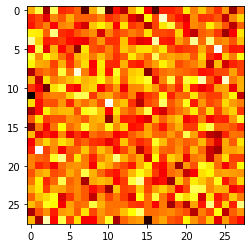

In [102]:
K = np.eye(784)
L = la.cholesky(K)
W = np.dot(L, np.random.randn(784))

fig = plt.figure()
plt.imshow(W.reshape(28, 28), cmap='hot')

In [107]:
W = V1_inspired_weights_for_center(784, 5, 3, [10, 10])

27.42504821250167